In [1]:
import warnings
warnings.filterwarnings("ignore")
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
from datetime import datetime, timedelta

In [2]:
data = pd.read_csv("cleaned_data.csv", index_col=0)

In [3]:
data.shape

(158723, 17)

In [4]:
eurdata = data[data['Currency']=='EUR']

In [5]:
eurdata.shape

(87409, 17)

In [6]:
eurdata['StrikePrice'] = eurdata['StrikePrice'].astype(float)
eurdata['StartPrice'] = eurdata['StartPrice'].astype(float)
eurdata['MaxPrice'] = eurdata['MaxPrice'].astype(float)
eurdata['MinPrice'] = eurdata['MinPrice'].astype(float)
eurdata['EndPrice'] = eurdata['EndPrice'].astype(float)

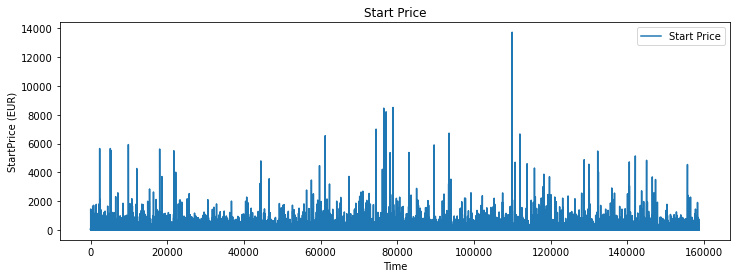

In [7]:
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(eurdata['StartPrice'], label = 'Start Price')
plt.xlabel('Time')
plt.ylabel('StartPrice (EUR)')
plt.legend(loc='upper right')
plt.title('Start Price')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
%matplotlib inline

series = eurdata.StartPrice.values
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -118.47459126691213
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.4304248199954612
Critial Values:
   5%, -2.861573069213271
Critial Values:
   10%, -2.566787601594207


<Figure size 72x72 with 0 Axes>

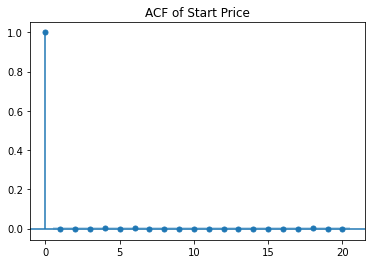

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create acf plot
plt.figure(figsize=(1, 1))

plot_acf(eurdata['StartPrice']**2, lags=20)
plt.title("ACF of Start Price")
plt.show()

<Figure size 72x72 with 0 Axes>

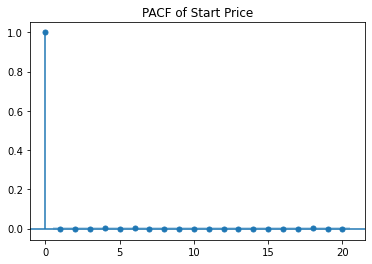

In [10]:
# create pacf plot
plt.figure(figsize=(1, 1))

plot_pacf(eurdata['StartPrice']**2, lags=20)
plt.title("PACF of Start Price")
plt.show()

In [11]:
# power transform
from scipy.stats import boxcox

startprice_transformed = boxcox(eurdata.StartPrice, 0)
returns = 100 * pd.DataFrame(startprice_transformed).pct_change().dropna()
returns = abs(returns)
returns = returns.mask(np.isinf(returns))
returns = returns.dropna()

In [61]:
series = returns
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -304.10081512162594
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.4304253397856868
Critial Values:
   5%, -2.861573298949126
Critial Values:
   10%, -2.5667877238751355


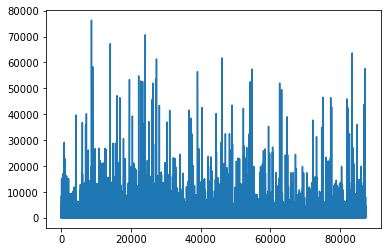

In [13]:
plt.plot(returns)

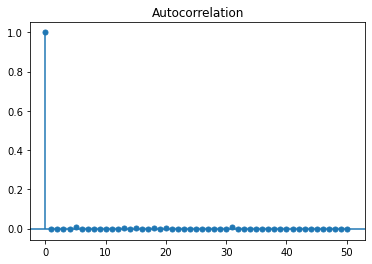

In [14]:
plot_acf(returns**2)
plt.show()

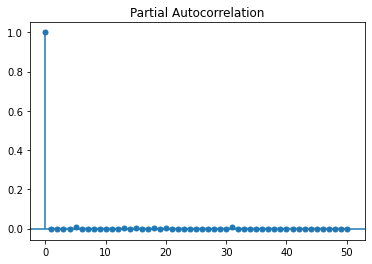

In [15]:
plot_pacf(returns**2)
plt.show()

#### GARCH(1,0) or ARCH(1) model

In [16]:
from arch import arch_model
model10 = arch_model(returns, p=1, q=0)
model10_fit = model10.fit()
model10_fit.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 783980.5351172888
Iteration:      2,   Func. Count:      8,   Neg. LLF: 783980.5362290283
Optimization terminated successfully    (Exit mode 0)
            Current function value: 783980.5351172888
            Iterations: 6
            Function evaluations: 8
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -783981.
Distribution:                  Normal   AIC:                       1.56797e+06
Method:            Maximum Likelihood   BIC:                       1.56800e+06
                                        No. Observations:                86801
Date:                Fri, May 06 2022   Df Residuals:                    86800
Time:                        18:02:29   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           413.3756      5.849     70.677      0.000 [4.019e+02,4.248e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.5075e+06  7.321e+04     20.592  3.231e-94  [1.364e+06,1.651e+06]
alpha[1]       0.0000  1.033e-04      0.000      1.000 [-2.025e-04,2.025e-04]
=============================================================================

Covariance estimator: robust
"""

In [17]:
warnings.filterwarnings("ignore")
start_time = datetime.now()

rolling_predictions10 = []
test_size10 = 360

for i in range(test_size10):
    train10 = returns[:-(test_size10-i)]
    model10 = arch_model(train10, p=1, q=0)
    model10_fit = model10.fit(disp='off')
    pred10 = model10_fit.forecast(horizon=1)
    rolling_predictions10.append(np.sqrt(pred10.variance.values[-1,:][0]))
end_time = datetime.now()
print("Time taken to execute ARCH(1) model predictions using 87409 records is ",end_time - start_time, " h:mm:ss")

Time taken to execute ARCH(1) model predictions using 87409 records is  0:01:02.027120  h:mm:ss


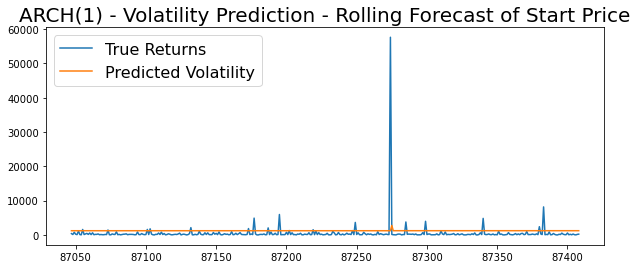

In [18]:
rolling_predictions10 = pd.Series(rolling_predictions10, index=returns.index[-360:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-360:])
preds, = plt.plot(rolling_predictions10)
plt.title('ARCH(1) - Volatility Prediction - Rolling Forecast of Start Price', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

#### GARCH(2,0) or ARCH(2)

In [19]:
from arch import arch_model
model20 = arch_model(returns, p=2, q=0)
model20_fit = model20.fit()
model20_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 781267.8308785993
Iteration:      2,   Func. Count:     11,   Neg. LLF: 781222.0371381209
Iteration:      3,   Func. Count:     16,   Neg. LLF: 781178.6815637584
Iteration:      4,   Func. Count:     20,   Neg. LLF: 781178.6815919019
Optimization terminated successfully    (Exit mode 0)
            Current function value: 781178.6815637584
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -781179.
Distribution:                  Normal   AIC:                       1.56237e+06
Method:            Maximum Likelihood   BIC:                       1.56240e+06
                                        No. Observations:                86801
Date:                Fri, May 06 2022   Df Residuals:                    86800
Time:                        18:03:32   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           426.6334     57.572      7.410  1.259e-13 [3.138e+02,5.395e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.5075e+06  9.056e+04     16.646  3.229e-62  [1.330e+06,1.685e+06]
alpha[1]       0.0000  1.294e-04      0.000      1.000 [-2.536e-04,2.536e-04]
alpha[2]       1.0000      0.255      3.917  8.951e-05      [  0.500,  1.500]
=============================================================================

Covariance estimator: robust
"""

In [20]:
start_time = datetime.now()

rolling_predictions20 = []
test_size20 = 360

for i in range(test_size20):
    train20 = returns[:-(test_size20-i)]
    model20 = arch_model(train20, p=2, q=0, dist = 'normal')
    model20_fit = model20.fit(disp='off')
    pred20 = model20_fit.forecast(horizon=1)
    rolling_predictions20.append(np.sqrt(pred20.variance.values[-1,:][0]))
end_time = datetime.now()
print("Time taken to execute ARCH(2) model predictions using 87409 records is ",end_time - start_time, " h:mm:ss")

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

Time taken to execute ARCH(2) model predictions using 87409 records is  0:01:25.408968  h:mm:ss


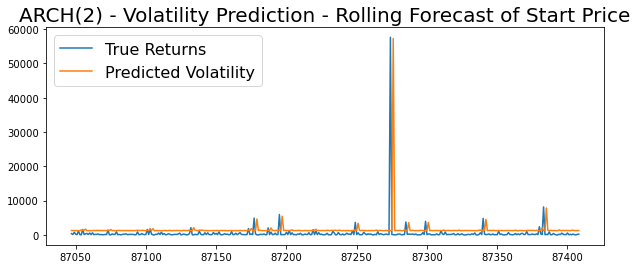

In [21]:
rolling_predictions20 = pd.Series(rolling_predictions20, index=returns.index[-360:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-360:])
preds, = plt.plot(rolling_predictions20)
plt.title('ARCH(2) - Volatility Prediction - Rolling Forecast of Start Price', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

#### GARCH(3,0)

In [22]:
model30 = arch_model(returns, p=3, q=0)
model30_fit = model30.fit()
model30_fit.summary()


Iteration:      1,   Func. Count:      7,   Neg. LLF: 781581.2934525444
Iteration:      2,   Func. Count:     13,   Neg. LLF: 781595.633125736
Iteration:      3,   Func. Count:     22,   Neg. LLF: 781210.4854496567
Iteration:      4,   Func. Count:     27,   Neg. LLF: 781210.4854706698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 781210.4854496567
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -781210.
Distribution:                  Normal   AIC:                       1.56243e+06
Method:            Maximum Likelihood   BIC:                       1.56248e+06
                                        No. Observations:                86801
Date:                Fri, May 06 2022   Df Residuals:                    86800
Time:                        18:04:58   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           425.4549     58.836      7.231  4.786e-13 [3.101e+02,5.408e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.5075e+06  9.105e+04     16.557  1.437e-61  [1.329e+06,1.686e+06]
alpha[1]       0.0000  1.298e-04      0.000      1.000 [-2.544e-04,2.544e-04]
alpha[2]       0.9861      0.255      3.870  1.091e-04      [  0.487,  1.486]
alpha[3]   2.3636e-03  8.776e-03      0.269      0.788 [-1.484e-02,1.956e-02]
=============================================================================

Covariance estimator: robust
"""

In [28]:
warnings.filterwarnings("ignore")
start_time = datetime.now()

rolling_predictions30 = []
test_size30 = 360

for i in range(test_size30):
    train30 = returns[:-(test_size30-i)]
    model30 = arch_model(train30, p=3, q=0)
    model30_fit = model30.fit(disp='off')
    pred30 = model30_fit.forecast(horizon=1)
    rolling_predictions30.append(np.sqrt(pred30.variance.values[-1,:][0]))
end_time = datetime.now()
print("Time taken to execute ARCH(3) predictions using 87409 records is ",end_time - start_time, " h:mm:ss")

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

C:\Users\Chrisia\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Time taken to execute ARCH(3) predictions using 87409 records is  0:01:57.381293  h:mm:ss


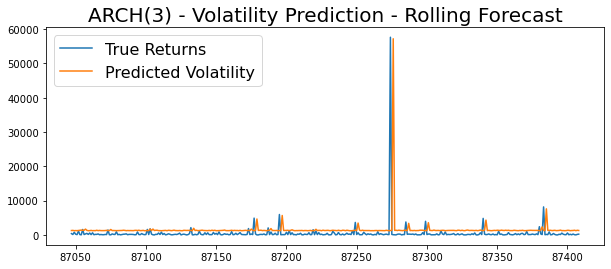

In [29]:
rolling_predictions30 = pd.Series(rolling_predictions30, index=returns.index[-360:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-360:])
preds, = plt.plot(rolling_predictions30)
plt.title('ARCH(3) - Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

#### GARCH(1,1)

In [30]:
model11 = arch_model(returns, p=1, q=1)
model11_fit = model11.fit()
model11_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1075486.2279215343
Iteration:      2,   Func. Count:     13,   Neg. LLF: 770688.7690133491
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1124813.35250127
Iteration:      4,   Func. Count:     26,   Neg. LLF: 777400.0746668126
Iteration:      5,   Func. Count:     34,   Neg. LLF: 819786.8944707285
Iteration:      6,   Func. Count:     43,   Neg. LLF: 770664.6543735868
Iteration:      7,   Func. Count:     48,   Neg. LLF: 819677.7783889521
Iteration:      8,   Func. Count:     55,   Neg. LLF: 770661.7487263414
Optimization terminated successfully    (Exit mode 0)
            Current function value: 770661.7487264427
            Iterations: 12
            Function evaluations: 55
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -770662.
Distribution:                  Normal   AIC:                       1.54133e+06
Method:            Maximum Likelihood   BIC:                       1.54137e+06
                                        No. Observations:                86801
Date:                Fri, May 06 2022   Df Residuals:                    86800
Time:                        18:30:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           413.1322      7.200     57.383      0.000 [3.990e+02,4.272e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0452e+05  1.408e+07  6.424e-02      0.949 [-2.669e+07,2.850e+07]
alpha[1]       0.0000  5.477e-03      0.000      1.000 [-1.073e-02,1.073e-02]
beta[1]        0.7000      4.667      0.150      0.881      [ -8.448,  9.848]
=============================================================================

Covariance estimator: robust
"""

In [31]:
start_time = datetime.now()

rolling_predictions11 = []
test_size11 = 360

for i in range(test_size11):
    train11 = returns[:-(test_size11-i)]
    model11 = arch_model(train11, p=1, q=1)
    model11_fit = model11.fit(disp='off')
    pred11 = model11_fit.forecast(horizon=1)
    rolling_predictions11.append(np.sqrt(pred11.variance.values[-1,:][0]))
end_time = datetime.now()
print("Time taken to execute GARCH(1,1) model predictions using 87409 records is ",end_time - start_time, " h:mm:ss")

Time taken to execute GARCH(1,1) model predictions using 87409 records is  0:01:42.050088  h:mm:ss


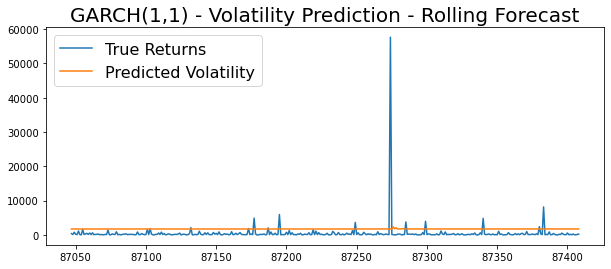

In [32]:
rolling_predictions11 = pd.Series(rolling_predictions11, index=returns.index[-360:])

plt.figure(figsize=(10,4))
true, = plt.plot(returns[-360:])
preds, = plt.plot(rolling_predictions11)
plt.title('GARCH(1,1) - Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

#### GARCH(2,2)

In [33]:
model22 = arch_model(returns, p=2, q=2)
model22_fit = model22.fit()
model22_fit.summary()


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1034134.2812966239
Iteration:      2,   Func. Count:     17,   Neg. LLF: 770687.4365188936
Iteration:      3,   Func. Count:     24,   Neg. LLF: 813997.8146665256
Iteration:      4,   Func. Count:     33,   Neg. LLF: 770680.0945812084
Optimization terminated successfully    (Exit mode 0)
            Current function value: 770680.0945923924
            Iterations: 8
            Function evaluations: 33
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -770680.
Distribution:                  Normal   AIC:                       1.54137e+06
Method:            Maximum Likelihood   BIC:                       1.54143e+06
                                        No. Observations:                86801
Date:                Fri, May 06 2022   Df Residuals:                    86800
Time:                        18:31:57   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           413.0598      6.069     68.065      0.000 [4.012e+02,4.250e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0452e+05  2.024e+06      0.447      0.655 [-3.062e+06,4.871e+06]
alpha[1]   6.0461e-03  3.952e-03      1.530      0.126 [-1.700e-03,1.379e-02]
alpha[2]   1.1214e-03  6.085e-03      0.184      0.854 [-1.081e-02,1.305e-02]
beta[1]    1.3899e-03      0.338  4.112e-03      0.997      [ -0.661,  0.664]
beta[2]        0.6931      0.365      1.898  5.769e-02   [-2.261e-02,  1.409]
=============================================================================

Covariance estimator: robust
"""

In [34]:
start_time = datetime.now()
rolling_predictions22 = []
test_size22 = 360

for i in range(test_size22):
    train22 = returns[:-(test_size22-i)]
    model = arch_model(train22, p=2, q=2)
    model_fit = model22.fit(disp='off')
    pred22 = model22_fit.forecast(horizon=1)
    rolling_predictions22.append(np.sqrt(pred22.variance.values[-1,:][0]))
end_time = datetime.now()
print("Time taken to execute GARCH(2,2) model predictions using 87409 records is ",end_time - start_time, " h:mm:ss")

Time taken to execute GARCH(2,2) model predictions using 87409 records is  0:02:05.212694  h:mm:ss


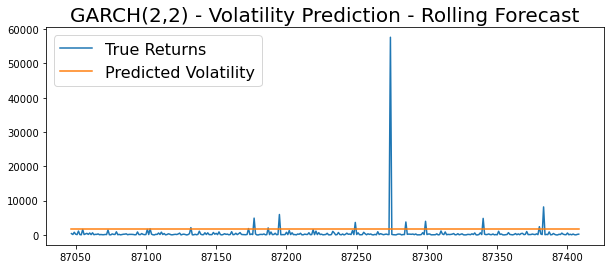

In [35]:
rolling_predictions22 = pd.Series(rolling_predictions22, index=returns.index[-360:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-360:])
preds, = plt.plot(rolling_predictions22)
plt.title('GARCH(2,2) - Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [ ]:
rolling_predictions22

#### GARCH(3,3)

In [36]:
model33 = arch_model(returns, p=3, q=3)
model33_fit = model33.fit()
model33_fit.summary()


Iteration:      1,   Func. Count:     10,   Neg. LLF: 970466.9470609282
Iteration:      2,   Func. Count:     21,   Neg. LLF: 770630.0754125844
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1095093.0006374482
Iteration:      4,   Func. Count:     42,   Neg. LLF: 810686.5150821721
Iteration:      5,   Func. Count:     55,   Neg. LLF: 846551.3810422946
Iteration:      6,   Func. Count:     66,   Neg. LLF: 770615.9264292385
Iteration:      7,   Func. Count:     76,   Neg. LLF: 811853.1637450479
Iteration:      8,   Func. Count:     88,   Neg. LLF: 819437.6669176227
Iteration:      9,   Func. Count:    100,   Neg. LLF: 770491.2959290533
Optimization terminated successfully    (Exit mode 0)
            Current function value: 770491.2958916024
            Iterations: 13
            Function evaluations: 100
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -770491.
Distribution:                  Normal   AIC:                       1.54100e+06
Method:            Maximum Likelihood   BIC:                       1.54107e+06
                                        No. Observations:                86801
Date:                Fri, May 06 2022   Df Residuals:                    86800
Time:                        18:34:04   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           413.6076      5.846     70.745      0.000 [4.021e+02,4.251e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0452e+05  8.419e+05      1.074      0.283 [-7.456e+05,2.555e+06]
alpha[1]   1.7817e-03  1.542e-03      1.156      0.248 [-1.240e-03,4.804e-03]
alpha[2]   5.9754e-04  2.998e-03      0.199      0.842 [-5.278e-03,6.473e-03]
alpha[3]       0.0112  8.961e-03      1.253      0.210 [-6.331e-03,2.879e-02]
beta[1]    2.8569e-04      0.400  7.143e-04      0.999      [ -0.784,  0.784]
beta[2]        0.6919      0.217      3.185  1.447e-03      [  0.266,  1.118]
beta[3]    2.8193e-04      0.340  8.299e-04      0.999      [ -0.666,  0.666]
=============================================================================

Covariance estimator: robust
"""

In [37]:
start_time = datetime.now()
rolling_predictions33 = []
test_size33 = 360

for i in range(test_size33):
    train33 = returns[:-(test_size33-i)]
    model33 = arch_model(train33, p=3, q=3)
    model33_fit = model33.fit(disp='off')
    pred33 = model33_fit.forecast(horizon=1)
    rolling_predictions33.append(np.sqrt(pred33.variance.values[-1,:][0]))
end_time = datetime.now()
print("Time taken to execute GARCH(3,3) model predictions using 87409 records is ",end_time - start_time, " h:mm:ss")

Time taken to execute GARCH(3,3) model predictions using 87409 records is  0:03:11.070125  h:mm:ss


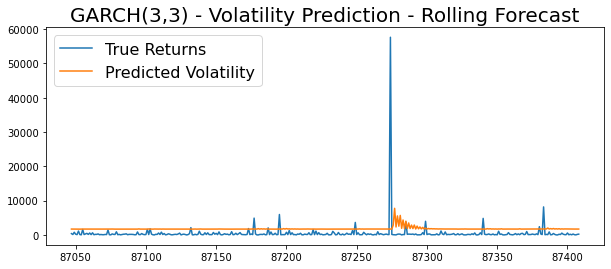

In [38]:
rolling_predictions33 = pd.Series(rolling_predictions33, index=returns.index[-360:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-360:])
preds, = plt.plot(rolling_predictions33)
plt.title('GARCH(3,3) - Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

### Performance Metrics

In [52]:
print("Results of sklearn.metrics ARCH(1):")
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(returns[-360:], rolling_predictions10[-360:])
mse = metrics.mean_squared_error(returns[-360:], rolling_predictions10[-360:])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(returns[-360:],rolling_predictions10[-360:])
ev_score = metrics.explained_variance_score(returns[-360:], rolling_predictions10[-360:])
print("Explained Variance Score is ",ev_score)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics ARCH(1):
Explained Variance Score is  -0.9373423706916968
MAE: 1496.7449893239113
MSE: 19786792.83359942
RMSE: 4448.234799737916
R-Squared: -1.0434978714910104


In [55]:
print("Results of sklearn.metrics GARCH(1,1):")
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(returns[-360:], rolling_predictions11[-360:])
mse = metrics.mean_squared_error(returns[-360:], rolling_predictions11[-360:])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(returns[-360:],rolling_predictions11[-360:])
ev_score = metrics.explained_variance_score(returns[-360:], rolling_predictions11)
print("Explained Variance Score is ",ev_score)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics GARCH(1,1):
Explained Variance Score is  -0.0005924616559711549
MAE: 1669.8379155318603
MSE: 11182742.796948161
RMSE: 3344.060824349366
R-Squared: -0.1549072805872198


In [60]:
print("Results of sklearn.metrics ARCH(2):")
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(returns[-360:], rolling_predictions20[-360:])
mse = metrics.mean_squared_error(returns[-360:], rolling_predictions20[-360:])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(returns[-360:],rolling_predictions20[-360:])
ev_score = metrics.explained_variance_score(returns[-360:], rolling_predictions20[-360:])
print("Explained Variance Score is ",ev_score)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics ARCH(2):
Explained Variance Score is  -0.9406313835411455
MAE: 1487.6571436550553
MSE: 19802049.971468467
RMSE: 4449.94943470917
R-Squared: -1.045073565390605


In [56]:
print("Results of sklearn.metrics ARCH(3):")
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(returns[-360:], rolling_predictions30[-360:])
mse = metrics.mean_squared_error(returns[-360:], rolling_predictions30[-360:])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(returns[-360:],rolling_predictions30[-360:])
ev_score = metrics.explained_variance_score(returns[-360:], rolling_predictions30)
print("Explained Variance Score is ",ev_score)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics ARCH(3):
Explained Variance Score is  -0.9373423706916968
MAE: 1496.7449893239113
MSE: 19786792.83359942
RMSE: 4448.234799737916
R-Squared: -1.0434978714910104


In [58]:
print("Results of sklearn.metrics GARCH(2,2):")
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(returns[-360:], rolling_predictions22[-360:])
mse = metrics.mean_squared_error(returns[-360:], rolling_predictions22[-360:])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(returns[-360:],rolling_predictions22[-360:])
ev_score = metrics.explained_variance_score(returns[-360:], rolling_predictions22)
print("Explained Variance Score is ",ev_score)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics GARCH(2,2):
Explained Variance Score is  2.220446049250313e-16
MAE: 1657.7410160223017
MSE: 11145946.135833029
RMSE: 3338.5544979576157
R-Squared: -0.15110707409094193


In [59]:
print("Results of sklearn.metrics GARCH(3,3):")
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(returns[-360:], rolling_predictions33[-360:])
mse = metrics.mean_squared_error(returns[-360:], rolling_predictions33[-360:])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(returns[-360:],rolling_predictions33[-360:])
ev_score = metrics.explained_variance_score(returns[-360:], rolling_predictions33)
print("Explained Variance Score is ",ev_score)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics GARCH(3,3):
Explained Variance Score is  -0.026320513940859547
MAE: 1717.2343980863147
MSE: 11578573.152665757
RMSE: 3402.7302497649966
R-Squared: -0.19578699748640838
